# Large-tile generation

TerraMind was pre-trained on small patches of 224x224 pixels. Passing larger inputs to the model works as long as it is a multiple of 16x16 pixel. However, this is outside the training scope and can lead to worse generation results or OOM errors. 
This example performs generation of a larger tile using the `tiled_inference` function provided by TerraTorch.  

In [1]:
# Cell 1: Install PyTorch (CPU version)
# For GPU version, replace `cpu` with your CUDA version (e.g., `cu118`),
# referring to https://pytorch.org/get-started/locally/ for the exact command.
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

# Cell 2: Install rioxarray
!pip install rioxarray

# Cell 3: Install matplotlib
!pip install matplotlib

# Cell 4: Install huggingface_hub
!pip install huggingface_hub

# Cell 5: Install terratorch
!pip install terratorch

!pip install diffusers

Looking in indexes: https://download.pytorch.org/whl/cpu


In [2]:
import os
import torch
import rioxarray as rxr
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download
from plotting_utils import plot_s2, plot_modality
from terratorch.registry import FULL_MODEL_REGISTRY
from terratorch.tasks.tiled_inference import tiled_inference

# Select device
if torch.cuda.is_available():
    device = 'cuda'    
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

/Users/boris/Documents/terramind/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Download Santiago large-scale example from Hugging Face (2000x2000 pixel)
if not os.path.isfile('../examples/S2L2A/Santiago.tif'):
    hf_hub_download(repo_id='ibm-esa-geospatial/Examples', filename='S2L2A/Santiago.tif', repo_type='dataset', local_dir='../examples/')

In [4]:
# Download Singpore large-scale example from Hugging Face (2000x2000 pixel)
if not os.path.isfile('../examples/S2L2A/Singapore_2025-01-09.tif'):
    hf_hub_download(repo_id='ibm-esa-geospatial/Examples', filename='S2L2A/Singapore_2025-01-09.tif', repo_type='dataset', local_dir='../examples/')

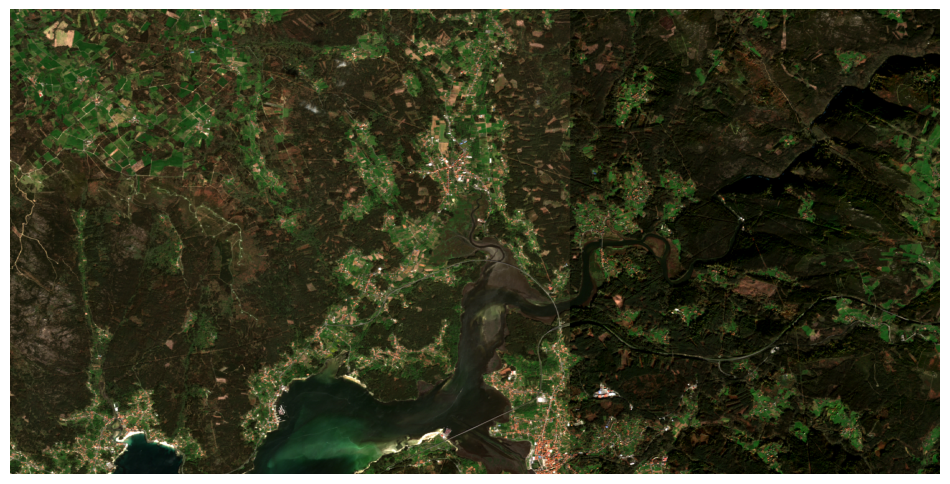

In [5]:
# Load Singapore tile
# data = rxr.open_rasterio('../examples/S2L2A/Singapore_2025-01-09.tif').values

# Load Santiago tile (alternative input)
data = rxr.open_rasterio('../examples/S2L2A/Santiago.tif').values

# Optionally reduce image size to speed up inference
data = data[:, 500:1500]

# Display the input 
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
plot_s2(data, ax=ax)
plt.show()

In [6]:
# Build input tensor and add batch dimension
input = torch.tensor(data, dtype=torch.float, device=device).unsqueeze(0)

# Build model
model = FULL_MODEL_REGISTRY.build(
    'terramind_v1_base_generate',
    modalities=['S2L2A'],
    output_modalities=['S1GRD', 'DEM', 'LULC', 'NDVI'],
    pretrained=True,
    standardize=True,
    timesteps=10,  # Number of diffusion steps
)

model = model.to(device)

# Run inference

`tiled_inference` can be used with any model as long as the output of the passed `forward` function returns a tensor. We therefore wrap the model and stack the generated modalities. 

In [19]:
import inspect
from terratorch.tasks.tiled_inference import tiled_inference
print(inspect.signature(tiled_inference))

(model_forward: collections.abc.Callable, input_batch: torch.Tensor, out_channels: int, inference_parameters: terratorch.tasks.tiled_inference.TiledInferenceParameters, **kwargs) -> torch.Tensor


In [31]:
import torch
from terratorch.tasks.tiled_inference import tiled_inference, TiledInferenceParameters
from terratorch.registry import FULL_MODEL_REGISTRY

# Define the device (MPS for Apple Silicon, CUDA for NVIDIA, else CPU)
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

def model_forward(x, **kwargs):
    # Pass kwargs (which will now primarily contain 'num_inference_steps' if sent this way) to the model's forward method
    generated = model(x, **kwargs)
    
    out = torch.concat([
        generated['S1GRD'],
        generated['DEM'],
        generated['LULC'],
        generated['NDVI']
    ], dim=1)
    
    return out 

out_channels = 2 + 1 + 10 + 1

inference_parameters_instance = TiledInferenceParameters(
    h_crop=256, 
    w_crop=256,
    h_stride=128,  
    w_stride=128,
)

model = FULL_MODEL_REGISTRY.build(      
    'terramind_v1_base_generate',      
    modalities=['S2L2A'],      
    output_modalities=['S1GRD', 'DEM', 'LULC', 'NDVI'],      
    pretrained=True,     
    standardize=True,     
    timesteps=10,  # This remains crucial for model building
)     
model = model.to(device)

# --- NEW ADDITIONS HERE ---
# Explicitly set batch_size and num_inference_steps as attributes on the model
# This is a common pattern if the model's internal logic expects these to be present
# as instance variables, not just as transient kwargs to forward().
model.batch_size = 16 # Setting batch_size as an attribute of the model instance
model.num_inference_steps = 10 # Setting num_inference_steps as an attribute of the model instance
# --- END NEW ADDITIONS ---

# Assume 'input' is defined and moved to device from previous steps.
input = input.to(device)

pred = tiled_inference(
    model_forward,
    input,
    out_channels=out_channels, 
    inference_parameters=inference_parameters_instance, 
    # Remove batch_size and num_inference_steps from here, as they are now set on the model directly
    # batch_size=16, 
    verbose=True,
    # num_inference_steps=10 # Remove from here
)
pred = pred.squeeze(0)

generated = {
    'S1GRD': pred[0:2],
    'DEM': pred[2],
    'LULC': pred[3:13].argmax(0),
    'NDVI': pred[-1],
}

100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


# Analyze the generations

Let's have a look at the generations. You can notice that all modalities capture the general features quite well but are often wrongly scaled. While S1 and NDVI values are closer to the mean values than the ground trough, DEM generations clearly shows the smaller patches of the tiled inference. The model fails to estimate the general elevation of each single patch. Because of the tiled inference, some generations can look a bit patchy, e.g., S1 below clouds as the model estimates the shoreline.

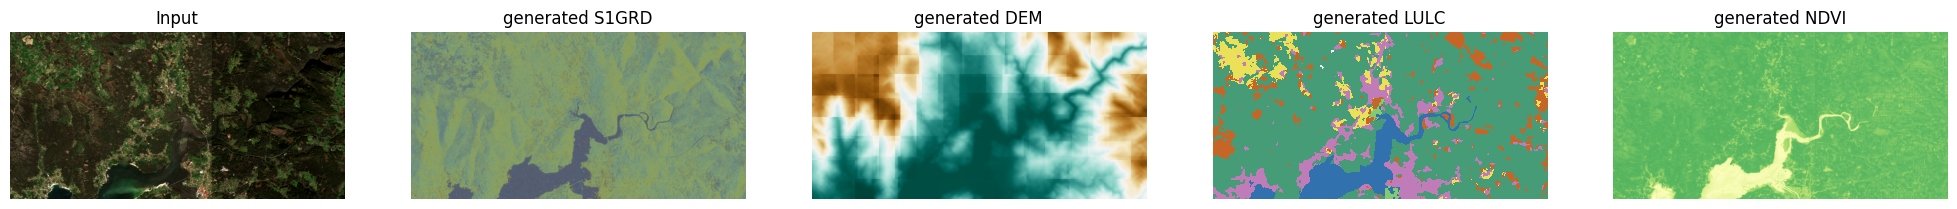

In [32]:
# Plot generations
n_plots = len(generated) + 1
fig, ax = plt.subplots(1, n_plots, figsize=(5 * n_plots, 5))

plot_s2(input, ax=ax[0])
ax[0].set_title('Input')

for i, (mod, value) in enumerate(generated.items()):
    plot_modality(mod, value, ax=ax[i + 1])

    ax[i+1].set_title('generated ' + mod)
    
plt.show()

# Compare generations in split view

We use leafmap for the interactive visualisation of a generation.

In [33]:
# Install leafmap
!pip install leafmap

python(6797) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Using cached ipywidgets-8.1.7-py3-none-any.whl.metadata (2.4 kB)
  Using cached widgetsnbextension-4.0.14-py3-none-any.whl.metadata (1.6 kB)
  Using cached jupyterlab_widgets-3.0.15-py3-none-any.whl.metadata (20 kB)
  Using cached beautifulsoup4-4.13.4-py3-none-any.whl.metadata (3.8 kB)
  Using cached soupsieve-2.7-py3-none-any.whl.metadata (4.6 kB)
  Using cached eval_type_backport-0.2.2-py3-none-any.whl.metadata (2.2 kB)
  Using cached jsonschema-4.24.0-py3-none-any.whl.metadata (7.8 kB)
  Using cached jsonschema_specifications-2025.4.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached referencing-0.36.2-py3-none-any.whl.metadata (2.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.0/568.0 kB 4.3 MB/s eta 0:00:00
Using cached ipywidgets-8.1.7-py3-none-any.whl (139 kB)
Using cached jupyterlab_widgets-3.0.15-py3-none-any.whl (216 kB)
Using cached widgetsnbextension-4.0.14-py3-none-any.whl (2.2 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 5.4 MB/s eta 0:00:00a 0:00:0

In [34]:
import leafmap
from plotting_utils import s2_to_rgb, s1_to_rgb, dem_to_rgb, ndvi_to_rgb, lulc_to_rgb


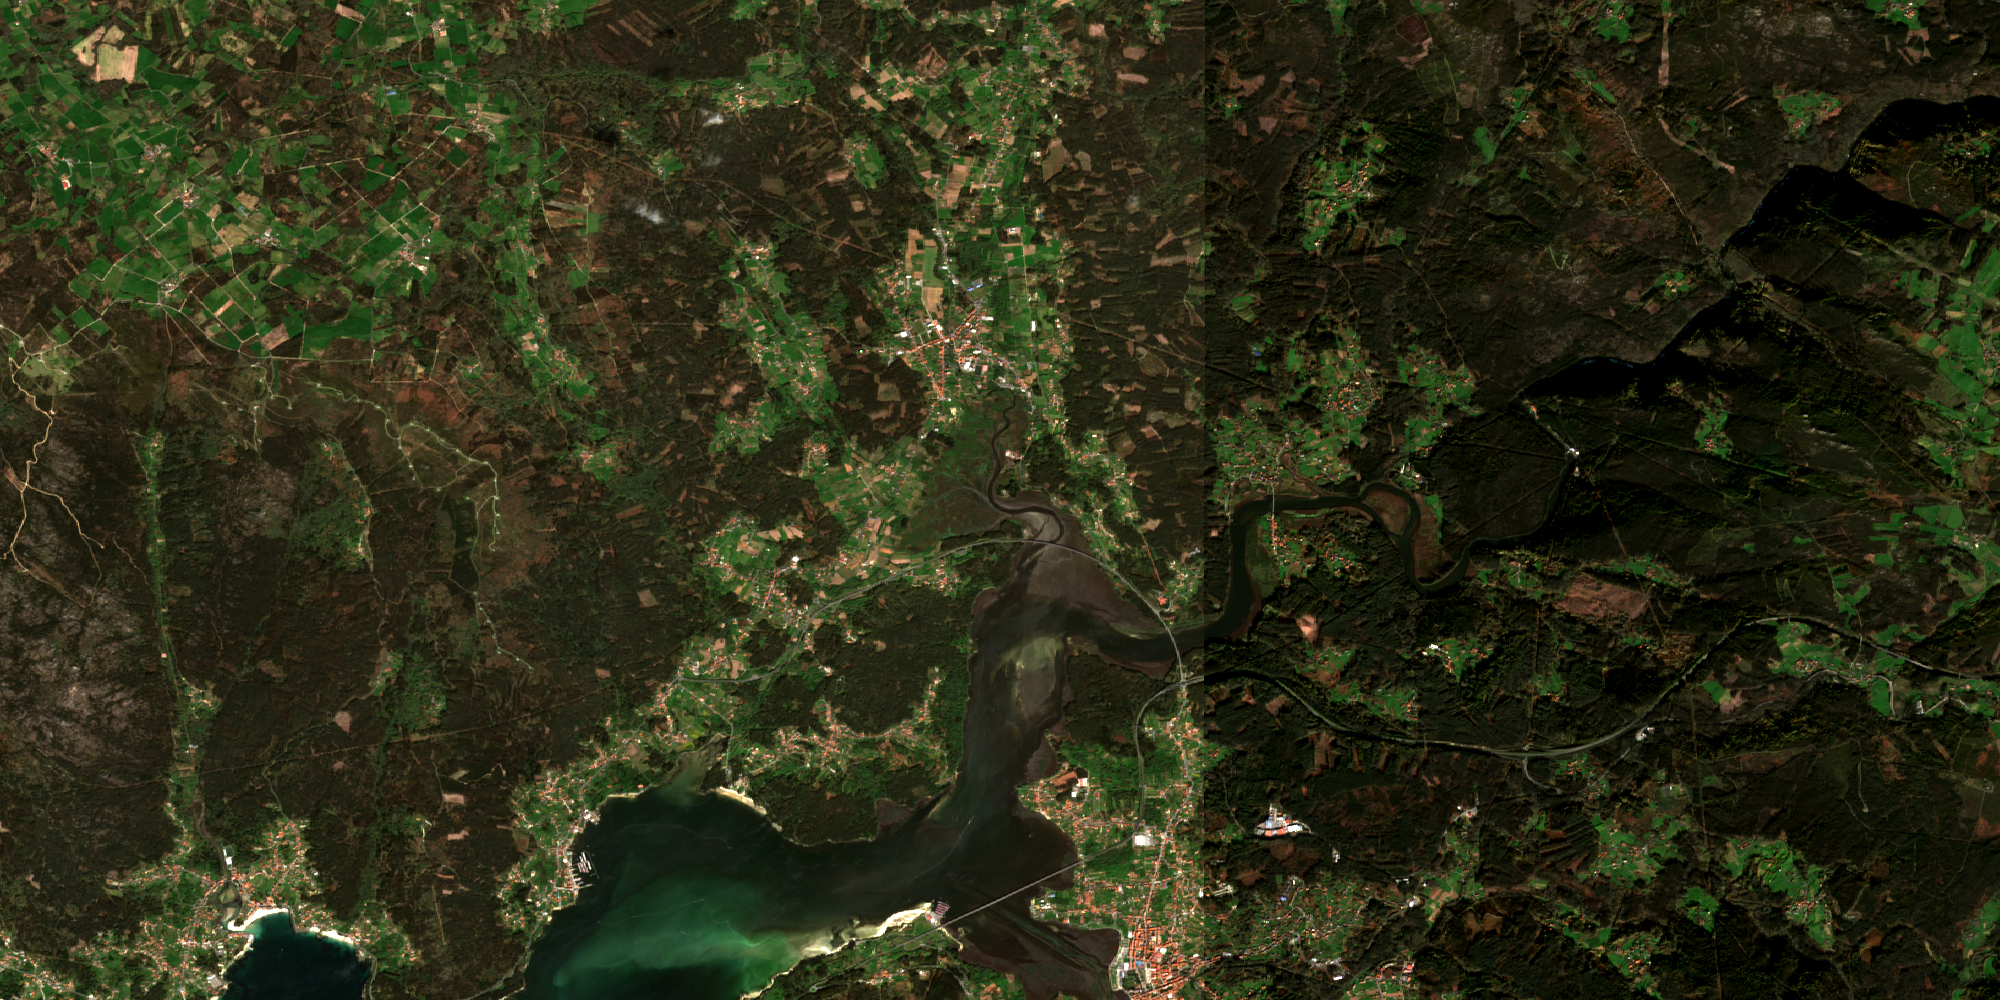
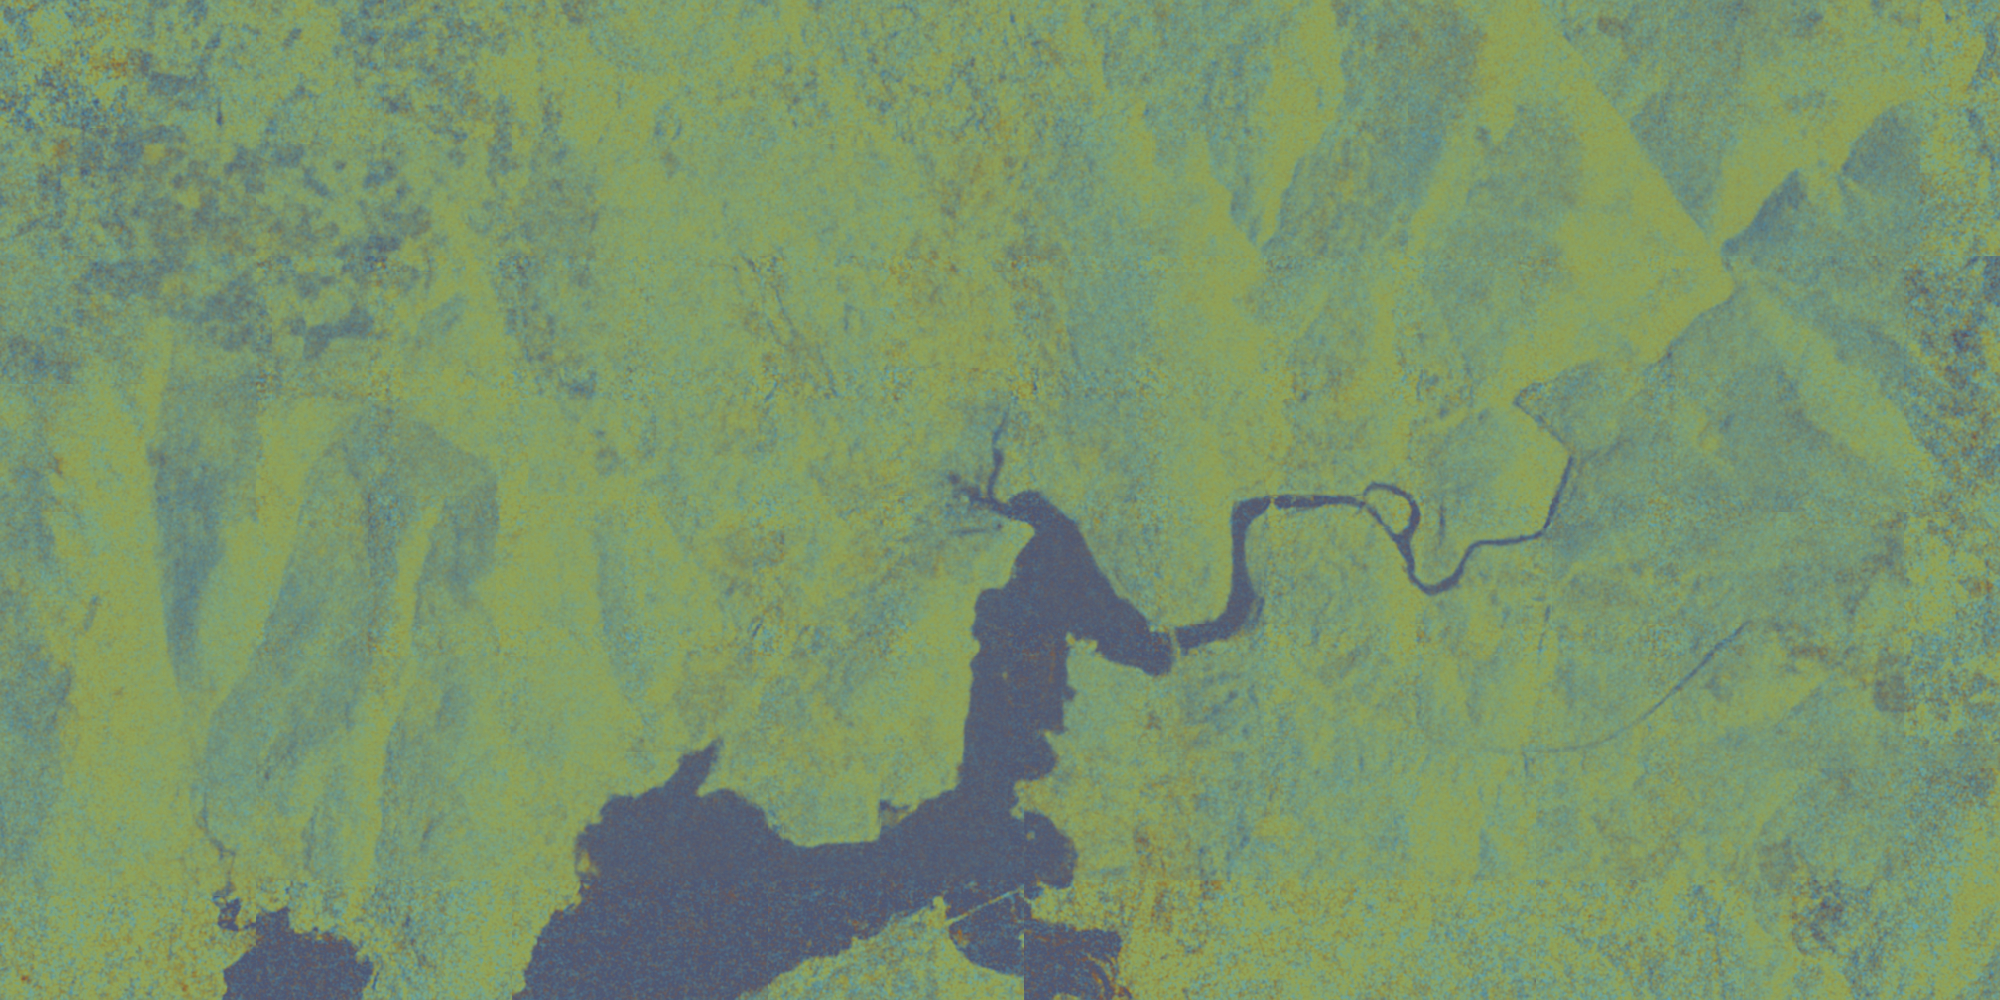

In [35]:
# Plot comparison using leafmap 
leafmap.image_comparison(
    s2_to_rgb(input),
    s1_to_rgb(generated['S1GRD']),
    # dem_to_rgb(generated['DEM']),
    # ndvi_to_rgb(generated['NDVI']),
    # lulc_to_rgb(generated['LULC']),
    label1="S-2 L2A",
    label2="Generated data",
    starting_position=50,
    out_html="image_comparison.html",
)